keras는 레이어 단위로 연산하고 가중치를 관리합니다. 딥러닝은 수십~수백개의 레이어로 이루어져 있기 때문에, 이를 일괄적으로 관리하는 툴이 필요합니다. 그것이 바로 Keras의 `Model`입니다.

## Keras의 Model

<img src="https://imgur.com/CBgGgkb.png" width="200">

딥러닝 모형은 일종의 함수입니다. 특정한 입력값을 받아서 여러 층의 레이어를 거친 후에 출력값을 생성하죠. 딥러닝 개발자들은 주로 위와 같이 Graph 형태로 자신의 모형을 표현합니다.  모형을 생성하기 위해서는 입력으로부터 출력까지 레이어를 단계 별로 **연결**해주면 됩니다.

### Model의 입력층, Input

Model은 입력과 출력만을 결정하면, 내부 로직에 의해 관련된 레이어들을 모두 수집하여 관리합니다. 

In [1]:
from tensorflow.keras.layers import Dense

hidden_layer = Dense(3, activation='relu', name='hidden')
output_layer = Dense(1, activation='sigmoid', name='output')

`Input`은 입력 텐서라는 특수한 텐서를 만들어주는 함수입니다. 다른 레이어와 다르게 레이어 인스턴스를 반환하는 것이 아니라 입력 텐서를 반환합니다. 입력 텐서는 텐서플로우 1.x대에 있었던, `tf.placeholder`와 같은 역할을 한다고 보면 됩니다.

In [2]:
from tensorflow.keras.layers import Input

inputs = Input((2,))
inputs

<tf.Tensor 'input_1:0' shape=(None, 2) dtype=float32>

해당 텐서를 레이어에 연결하면, 해당 텐서에 레이어의 연산이 적용된 결과 텐서가 나옵니다.

In [3]:
hidden = hidden_layer(inputs)
hidden

<tf.Tensor 'hidden/Identity:0' shape=(None, 3) dtype=float32>

이를 순차대로 또 다음 레이어에 연결하면 아래와 같이 생성됩니다.

In [4]:
output = output_layer(hidden)
output

<tf.Tensor 'output/Identity:0' shape=(None, 1) dtype=float32>

### 모델 선언하기

모델은 선언하는 것은 간단합니다. `Input`층부터 이어져서 출력층까지의 연결한 후, 입력값과 출력값을 선언해주면 됩니다.


In [5]:
from tensorflow.keras.models import Model

model = Model(inputs, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
hidden (Dense)               (None, 3)                 9         
_________________________________________________________________
output (Dense)               (None, 1)                 4         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


우리가 구성한 모델을 시각화해보도록 하겠습니다.

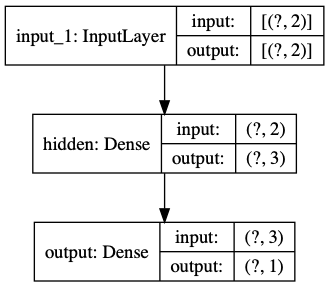

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Model의 레이어 공유

현재 위에서 주어진 hidden_layer와 output_layer를 가지고 2개의 모형을 만들어 보도록 하겠습니다.

In [9]:
model_1 = Model(inputs, output)
model_2 = Model(inputs, output)

이 때 두 모델 model_1과 model_2는 같은 가중치를 **공유**하고 있습니다.

In [10]:
for w1, w2 in zip(model_1.weights, model_2.weights):
    print(f"{w1.name} :", id(w1) == id(w2))

hidden/kernel:0 : True
hidden/bias:0 : True
output/kernel:0 : True
output/bias:0 : True


이와 같이 가중치를 공유하기 때문에, model_1 내의 `hidden`의 가중치를 바꾸면 `model_2`의 가중치도 같이 바뀝니다. model_1의 첫번째 가중치를 가져와서 변경하면 model_2의 첫번째 가중치도 똑같이 변경됩니다.

In [11]:
W = model_1.weights[0]
W.assign_add(np.ones((2,3)))
W

<tf.Variable 'hidden/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[0.0150755 , 0.89469343, 0.32789516],
       [0.90052336, 0.7360231 , 1.407175  ]], dtype=float32)>

In [12]:
# 가중치를 공유하므로, model_1의 weight와 동일
model_2.weights[0]

<tf.Variable 'hidden/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[0.0150755 , 0.89469343, 0.32789516],
       [0.90052336, 0.7360231 , 1.407175  ]], dtype=float32)>

케라스에서 이렇게 레이어 공유하는 코드 스타일은 Auto-Encoder를 작성할 때나 Transfer Learning, GAN 같이 모델끼리 가중치를 공유해야 하는 경우가 많은 경우 굉장히 편리합니다.

#### c.f) 모델 복제하기

가중치를 공유하지 않고, 복제만 하고 싶은 경우에는 clone_model을 이용하면 됩니다.

In [13]:
from tensorflow.keras.models import clone_model

model_2 = clone_model(model_1)

### 모델 내 레이어 가져오기

`.get_layer`를 통해 간단히 가져올 수 있습니다. 

In [14]:
inputs = Input((2,))
hidden = Dense(3, activation='relu', name='hidden')(inputs)
output = Dense(1, activation='sigmoid', name='output')(hidden)
model = Model(inputs, output)

keras로 모델링할 때는 위와 같이 레이어를 따로 변수로 지정하지 않고, 바로 생성 후 텐서로 연결하는 식으로 코드를 짭니다. 이렇게 작성할 경우, 우리가 레이어 인스턴스를 가져오기 위해서 `.get_layer`를 이용합니다. `.get_layer`를 이용하기 위해서는 위와 같이 레이어의 이름(name)을 지정하는 것이 좋습니다.

In [15]:
layer = model.get_layer('hidden') # hidden 레이어 가져오기
layer = model.get_layer('output') # output 레이어 가져오기

해당 레이어의 출력 텐서를 가져오고 싶으면, `.output`을 이용하면 됩니다.

In [16]:
layer.output

<tf.Tensor 'output_2/Identity:0' shape=(None, 1) dtype=float32>

그리고 전체 모델에 대한 정보는 `model.get_config()`로 가져올 수 있습니다.

In [17]:
model.get_config()

{'name': 'model_3',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 2),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_2'},
   'name': 'input_2',
   'inbound_nodes': []},
  {'class_name': 'Dense',
   'config': {'name': 'hidden',
    'trainable': True,
    'dtype': 'float32',
    'units': 3,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'hidden',
   'inbound_nodes': [[['input_2', 0, 0, {}]]]},
  {'class_name': 'Dense',
   'config': {'name': 'output',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',

Tensorflow에서 모델의 구조는 내부적으로 `Graph`의 형태로 관리됩니다. 하지만 Keras API에서는 config json 포맷으로 관리됩니다. 그래서 Tensorflow를 저장할 때에는 모델의 연산을 정의하는 Graph와 모델 내 가중치를 의미하는 Checkpoint를 따로 저장했다면, Keras에서는 모델의 연산을 정의하는 Config 와 모델 내 가중치를 의미하는 weights를 따로 저장합니다.

### 모델에서 관리하고 있는 가중치 가져오기

현재 모델에서의 가중치 중에서 학습해야 할 가중치는 `trainable_variables`에 있습니다.

In [18]:
model.trainable = True

model.trainable_variables

[<tf.Variable 'hidden_2/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[ 0.43517053,  0.34676707,  0.17851353],
        [ 0.4142151 ,  0.5682963 , -0.11995953]], dtype=float32)>,
 <tf.Variable 'hidden_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'output_2/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-1.1316392 ],
        [-0.8318955 ],
        [-0.90949464]], dtype=float32)>,
 <tf.Variable 'output_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

해당 모델이 학습하지 않도록 만들고 싶다면, 아래와 같이 `trainable`을 False로 두면 됩니다.

In [19]:
model.trainable = False

model.trainable_variables

[]

대신 학습대상이 아닌 가중치들은 `non_trianable_variables`에 들어갑니다.

In [20]:
model.non_trainable_variables

[<tf.Variable 'hidden_2/kernel:0' shape=(2, 3) dtype=float32, numpy=
 array([[ 0.43517053,  0.34676707,  0.17851353],
        [ 0.4142151 ,  0.5682963 , -0.11995953]], dtype=float32)>,
 <tf.Variable 'hidden_2/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'output_2/kernel:0' shape=(3, 1) dtype=float32, numpy=
 array([[-1.1316392 ],
        [-0.8318955 ],
        [-0.90949464]], dtype=float32)>,
 <tf.Variable 'output_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

종종 Transfer Learning등을 이용할 때, 특정 층만 학습에서 제외해야 할 때가 있습니다. 그런 경우 우리는 Model 내 Layer 별로 trainable를 지정해줄 수 있습니다.

### 모델의 연산 수행하기

모델의 연산은 레이어의 연산과 마찬가지로, `model()`의 형태로 연산을 수행합니다. 레이어가 함수와 같이 동작하듯, 모델 또한 함수처럼 동작합니다. 모델은 결국 여러 함수가 단계 별로 진행되는 복잡한 함수입니다. 

In [21]:
import tensorflow as tf
input_values = tf.constant([[0.5,0.7],
                            [0.3,0.2,],
                            [0.1,-.9]], tf.float32)

y_pred = model(input_values)
y_pred

<tf.Tensor: id=272, shape=(3, 1), dtype=float32, numpy=
array([[0.25839537],
       [0.38948756],
       [0.47142413]], dtype=float32)>

#### c.f) training Phase 설정하기

혹시 추론환경과 학습환경에서 다르게 돌아가는 Dropout이나 Batch Normalization이 있을 때에는 어떻게 구성해야 할까요? 바로 입력값 부분에 `training`을 통해 조작할 수 있습니다.

In [22]:
# 예제) dropout model
from tensorflow.keras.layers import Dropout

inputs = Input((10,))
dropout = Dropout(0.5)(inputs)

dropout_model = Model(inputs, dropout)

##### case) `training=True`  일 때

In [23]:
xs = np.ones([1,10],np.float32)
dropout_model(xs, training=True)

<tf.Tensor: id=327, shape=(1, 10), dtype=float32, numpy=array([[2., 0., 0., 2., 0., 2., 2., 2., 0., 2.]], dtype=float32)>

##### case) `training=False` 일 때

In [24]:
xs = np.ones([1,10],np.float32)
dropout_model(xs, training=False)

<tf.Tensor: id=334, shape=(1, 10), dtype=float32, numpy=array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

### 모델을 저장하기 

텐서플로우 1.x에서는 연산을 정의하는 Graph 파일(`.pbtxt`)와 가중치를 담은 weight 파일(`.ckpt`)로 나누어 모델을 저장하였습니다. 이러한 파일 포맷은 일반 사용자나 연구자가 다루기에 까다로웠습니다. 케라스에서는 익숙한 형태의 포맷인 `json/yaml`과 `.h5`으로 모델을 저장합니다. 

모델의 구조을 정의하는 정보는 `.json/.yaml`으로 저장하고, 모델 내 가중치를 저장하는 정보는 `.h5`로 저장합니다.


#### 모델의 구조를 텍스트화하기 

케라스에서는 .json와 .yaml, 두가지 형태를 지원합니다.

In [25]:
model.to_yaml()
model.to_json()

'{"class_name": "Model", "config": {"name": "model_3", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 2], "dtype": "float32", "sparse": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "Dense", "config": {"name": "hidden", "trainable": false, "dtype": "float32", "units": 3, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "hidden", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "Dense", "config": {"name": "output", "trainable": false, "dtype": "float32", "units": 1, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "confi

#### 모델의 가중치를 저장하기

In [26]:
model.save_weights("./weights.h5")

위와 같이 저장된 `.h5`파일은 실제로 아래와 같이 각 레이어의 이름에 매칭되어 저장됩니다. 

In [27]:
import h5py

with h5py.File('./weights.h5') as f:
    for group in f.values():
        for layer, weight in group.items():
            print("layer name :", layer)
            for key, value in weight.items():
                print(key,": ", value[:])
        print()

layer name : hidden_2
bias:0 :  [0. 0. 0.]
kernel:0 :  [[ 0.43517053  0.34676707  0.17851353]
 [ 0.4142151   0.5682963  -0.11995953]]


layer name : output_2
bias:0 :  [0.]
kernel:0 :  [[-1.1316392 ]
 [-0.8318955 ]
 [-0.90949464]]



#### 함께 저장하기

json과 h5파일을 따로 저장하는 것은 번거로운 일입니다. 그래서 케라스에서는 h5파일 하나로 저장하는 방식도 제공합니다.

In [28]:
model.save("./model.h5")

해당 구조는 아래와 같이 저장되어 있습니다.

In [29]:
with h5py.File('./model.h5') as f:
    print("model의 configuration 정보 :")
    print(json.loads(f.attrs['model_config']))
    print("\n\n")
    
    print("model의 weight 정보 : ")
    for group in f['model_weights'].values():
        for layer, weight in group.items():
            print("layer name :", layer)
            for key, value in weight.items():
                print(key,": ", value[:])
        print()

model의 configuration 정보 :
{'class_name': 'Model', 'config': {'name': 'model_3', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 2], 'dtype': 'float32', 'sparse': False, 'name': 'input_2'}, 'name': 'input_2', 'inbound_nodes': []}, {'class_name': 'Dense', 'config': {'name': 'hidden', 'trainable': False, 'dtype': 'float32', 'units': 3, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'name': 'hidden', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'class_name': 'Dense', 'config': {'name': 'output', 'trainable': False, 'dtype': 'float32', 'units': 1, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'cla